In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.stats as stats
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

#import testing
import sys
sys.path.append("../")
import vuong_plots

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
#generate the sample
def gen_data(beta1 = 5, beta2 = 6, alpha = 6):
    nobs = 1000
    x = np.random.uniform(low=0, high=1., size=nobs)
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)# np.random.uniform(low=-1., high=1., size=nobs) # 
    y = alpha + beta1 * x + beta2*x**2  + e
    y = .001 + y*(y>=.0001) # ensure that we don't get negative ys...
    return y,x,nobs

In [6]:
def compute_loglike(resid):
    sigma = np.sqrt(np.sum(resid**2)/resid.shape[0])
    ll = np.log(stats.norm.pdf(resid,loc=0,scale=sigma))
    return ll


def compute_score(yn,xn,params,exp_resid=False):
    
    if exp_resid:
        yn = np.log(yn)
    
    xn = sm.add_constant(xn)
    resid = yn - np.matmul(xn,params)
    if exp_resid:
        resid = np.exp(resid)
    
    k = len(params)
    scale = (resid**2).mean()
    
    tile_resid = np.tile( resid, k)
    tile_resid = np.reshape(tile_resid, (k,xn.shape[0]) ).transpose()
    grad = tile_resid*xn/scale     
    return grad
    
def compute_hess(yn,xn,params):
    pass


def setup_shi(yn,xn):
    
    # model 1 grad, etc.
    model1 = sm.OLS(np.log(yn),sm.add_constant(xn))
    model1_fit = model1.fit(disp=False)
    k1 = len(model1_fit.params)
    
    ll1 = compute_loglike(np.exp(model1_fit.resid))
    grad1 =  compute_score(yn,xn,model1_fit.params,exp_resid=True)    
    scale1 = (np.exp(model1_fit.resid)**2).mean()
    hess1 = model1.hessian(model1_fit.params,scale=2*scale1)
    
    #model 2 grad, etc.
    model2 = sm.OLS(yn,sm.add_constant(xn))
    model2_fit = model2.fit(disp=False)
    k2 = len(model1_fit.params)
    
    ll2 = compute_loglike(model2_fit.resid)
    grad2 =  compute_score(yn,xn,model2_fit.params)
    hess2 = model2.hessian(model2_fit.params)
    
    return ll1,grad1,hess1,ll2,k1, grad2,hess2,k2

yn,xn,nobs = gen_data()
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)

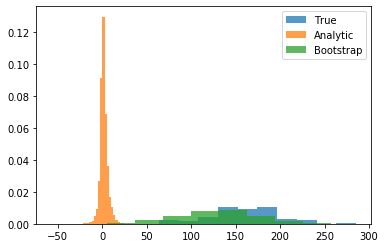

In [7]:
true_stats = vuong_plots.plot_true(gen_data,setup_shi)

yn,xn,nobs = gen_data()
anayltic_stats = vuong_plots.plot_analytic(yn,xn,nobs,setup_shi)
bootstrap_stats = vuong_plots.plot_bootstrap(yn,xn,nobs,setup_shi)
plt.legend()
plt.show()

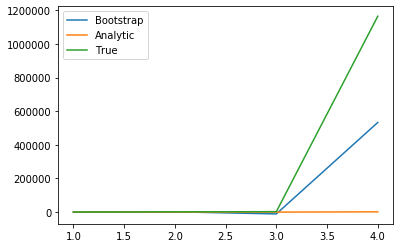

In [8]:
plt.plot(range(1,5),  [ stats.kstat(bootstrap_stats,n=i) for i in range(1,5)], label="Bootstrap")
plt.plot(range(1,5),  [ stats.kstat(anayltic_stats,n=i) for i in range(1,5)], label="Analytic")
plt.plot(range(1,5),  [ stats.kstat(true_stats,n=i) for i in range(1,5)], label="True")

plt.legend()